In [1]:
import sys
import os
from imageio import imread
from PIL import Image
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import math 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import itertools
import os
from imageio import imread
from PIL import Image
from glob import glob
import json
import platform

from skimage import io

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
import timeit
import time

**Display enviroment**

In [3]:
!nvidia-smi

Sun Oct 24 00:02:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
current_system = platform.system()

**Mount google drive:**

In [5]:
if 'Linux' == current_system:
  from google.colab import drive
  drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [6]:
#debug = True

In [7]:
debug = False

**Utility Functions**

In [8]:
def dump_list(file_name, a_list):
  file_full_path = os.path.join(project_root_path_string, file_name)
  with open(file_full_path, 'w') as fp:
    json.dump(a_list, fp)

In [9]:
def load_to_list(file_name):

  a_list = []
  file_full_path = os.path.join(project_root_path_string, file_name)
  with open(file_full_path, 'r') as fp:
    a_list = json.load(fp)

  return a_list

In [10]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

In [11]:
def pred(model, img):
    with torch.no_grad():#Always turn off gradients when evaluating!
        c, w, h = img.shape#Whats the width/height of the image
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img)
        x = img.reshape(1,-1,w,h)#reshape it as (B, C, W, H)
        logits = model(x) #Get the logits
        
        y_hat = F.softmax(logits, dim=1)#Turn into probabilities 
        
        
        return y_hat.cpu().numpy().flatten()#convert prediction to numpy array. 

In [12]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [13]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)
        
        y_hat = model(inputs)
        
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

Define a function that reload states to the given model and optimizer from the checkpoint file, and it also returns previously trained results and the latest epoch number:

In [14]:
# reload the states to the given model and optimizer from the checkpoint file
def resume_states(checkpoint_file, model, optimizer, is_debug=False):
  del_opt = False
  results = {}
  last_epoch = -1

  if(checkpoint_file and os.path.isfile(checkpoint_file)):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])

    if(optimizer != None):
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
      #Create a default AdamW optimizer, then load state
      optimizer = torch.optim.AdamW(model.parameters())
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    results = checkpoint['results']
    last_epoch = checkpoint['epoch']

    if(is_debug):
      print('Loading checkpoint file:', checkpoint_file)
      print('last_epoch: ', last_epoch)
      print('results:', results)
      total_train_time = results["total time"][-1]
      print('total_train_time:', total_train_time)
      print('del_opt:', del_opt)
      print(model)
  
  if(optimizer==None):
    optimizer = torch.optim.AdamW(model.parameters())
    del_opt = True

  return model, optimizer, last_epoch, results, del_opt

In [15]:
def train_dl_model(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
    checkpoint_file -- the file saves the training status, so next invocation of the function can pick up what was left.
    optimizer -- the method used to alter the gradients for learning. 
    
    """
    results = {}
    last_epoch = -1
    delete_opt = True
    total_train_time = 0.0 #How long have we spent in the training loop?
    the_optimizer = optimizer
    the_model = model

    ############################################################################################################################
    ###### Attempt to resume previous training states whenever a specified checkpoint file exists.
    ############################################################################################################################
    the_model, the_optimizer, last_epoch, results, delete_opt = resume_states(checkpoint_file, model, optimizer, is_debug=True)

    if(len(results)!=0):  
      total_train_time = results["total time"][-1]  # Restore the latest total training time 

    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )
        
     
    if(len(results)==0):
      #Initialize every item with an empty list
      for item in to_track:
        results[item] = []

    del_opt = delete_opt

    #Place the model on the correct compute resource (CPU or GPU)
    the_model.to(device)

    if(last_epoch==-1):  #No last_epoch is found in checkpoint file, so it indicates training starts from brand new and not from resumed state
      start_epoch = 0
    else:
      start_epoch = last_epoch + 1

    for epoch in tqdm(range(start_epoch, epochs), desc="Epoch", disable=disable_tqdm):
        the_model = the_model.train()#Put our model in training mode

        total_train_time += run_epoch(the_model, the_optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        
      
        if val_loader is not None:
            the_model = the_model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(the_model, the_optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")
                
        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()
                
        if test_loader is not None:
            the_model = the_model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(the_model, the_optimizer, val_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
        
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': the_model.state_dict(),
                'optimizer_state_dict': the_optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del the_optimizer

    return pd.DataFrame.from_dict(results)

**Function to plot the confusion Matrix**

In [16]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Function that constructs and draws a confusion matrix of a given model with testing DataLoader:**

In [17]:
def construct_and_plot_confusion_matrix(model, class_labels, test_loader, model_name):
  preds = []
  truths = []
  
  model.eval()
  with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        
        #if img_tab_comb == True:
            #img_input = inputs['image_input']
            #tab_input = inputs['tabular_input']
            #data_inputs = img_input
        #else:
            #data_inputs = inputs
            
        data_inputs = inputs
        
        if debug == True:
          print(data_inputs)

        pred = model(moveTo(data_inputs, device))
        pred = torch.argmax(pred, dim=1).cpu().numpy()
        
        preds.extend(pred.ravel())
        truths.extend(labels.numpy().ravel())
  
  acc_score = accuracy_score(preds, truths)
  
  if debug==True:
    print("Accuracy: ", accuracy_score(preds, truths))
    print('preds:',preds)
    print('truth:',truths)
    print('class_labels:',list(class_labels))

  cm = confusion_matrix(truths, preds)
  cls_report = classification_report(truths, preds, labels=list(class_labels))
  plot_confusion_matrix(cm, class_labels, 'Confusion Matrix (' + model_name + ')')

  return cm, acc_score, cls_report

In [18]:
set_seed(42)

**Create project root path:**

In [19]:
if 'Linux' == current_system:
  project_root_path_string = '/content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/'
else:
  project_root_path_string = 'C:\\Users\\Yunpe\\Documents\\Data606\\Project\\Skin_Cancer_ML_DL\\Skin_Cancer_Analysis'

print("project_root_path_string:", project_root_path_string)

project_root_path_string: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/


In [20]:
sys.path.append(project_root_path_string)

sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/']

**Get the root data directory:**

In [21]:
data_root_path = os.path.join(project_root_path_string, 'data') 

print("data_root_path:", data_root_path)

data_root_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data


**Get raw image directory:**

In [22]:
raw_image_data_path =  os.path.join(data_root_path, 'raw_image_data') 
print("raw_image_data_path:", raw_image_data_path)

raw_image_data_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data/raw_image_data


**Get the tabular data path:**

In [23]:
tabular_data_path = os.path.join(data_root_path, 'tabular_data') 

print("tabular_data_path:", tabular_data_path)

tabular_data_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data/tabular_data


**Get the skin_categorires path:**

In [24]:
processed_image_data_path =  os.path.join(data_root_path, 'processed_image_data') 
print("processed_image_data_path:", processed_image_data_path)

skin_categories_path =  os.path.join(processed_image_data_path, 'skin_categories') 
print("skin_categories_path:", skin_categories_path)

processed_image_data_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data/processed_image_data
skin_categories_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data/processed_image_data/skin_categories


In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

**Define some constants:**

In [26]:
IMG_W = 224  # image width
IMG_H = 224  # image height
IMG_C = 3  # image channel
RGB_MAX = 255  # max RGB value

B = 128 # batch size
D = IMG_W * IMG_H # image total pixels
C = IMG_C  # number of channels
NUM_CLASSES = 6 # number of classes
filters = 128 # number of filters
k = 3 # kernel size

epochs = 50

**Construct a pandas dataframe dataset that combines image information and encoded categorical data:**

**Read csv file into a panda data frame:**

In [27]:
data_pd = pd.read_csv(os.path.join(tabular_data_path, 'No_Nan_Metadata.csv'))

In [28]:
data_pd

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed,image_path,cell_type,cell_type_label
0,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1
1,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1
2,PAT_778,1471,False,True,GERMANY,ITALY,52,False,FEMALE,False,True,True,True,3.0,FACE,15.0,10.0,BCC,False,True,False,True,True,True,PAT_778_1471_835.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1
3,PAT_117,179,False,False,POMERANIA,POMERANIA,74,True,FEMALE,False,False,False,False,1.0,FACE,15.0,10.0,BCC,True,True,True,False,True,True,PAT_117_179_983.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1
4,PAT_705,4015,False,True,GERMANY,GERMANY,58,True,FEMALE,True,True,True,True,1.0,FOREARM,9.0,7.0,ACK,False,True,False,False,False,False,PAT_705_4015_413.png,False,/content/gdrive/My Drive/Data606/Project/Skin_...,Actinic Keratosis,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,PAT_386,785,True,False,POMERANIA,POMERANIA,66,False,MALE,True,False,True,True,2.0,EAR,20.0,15.0,ACK,True,False,True,False,True,True,PAT_386_785_536.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Actinic Keratosis,0
1470,PAT_273,421,False,False,POMERANIA,POMERANIA,41,True,MALE,False,False,False,False,2.0,FACE,9.0,5.0,BCC,True,UNK,True,UNK,True,True,PAT_273_421_905.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1
1471,PAT_491,934,False,False,POMERANIA,POMERANIA,43,True,FEMALE,True,True,False,False,2.0,FACE,9.0,5.0,SCC,True,UNK,False,UNK,True,True,PAT_491_934_46.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Squamous Cell Carcinoma,4
1472,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,CHEST,13.0,12.0,BCC,True,True,False,True,False,False,PAT_46_880_140.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1


In [29]:
data_pd.columns

Index(['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father',
       'background_mother', 'age', 'pesticide', 'gender',
       'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'fitspatrick', 'region', 'diameter_1',
       'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed',
       'elevation', 'img_id', 'biopsed', 'image_path', 'cell_type',
       'cell_type_label'],
      dtype='object')

In [30]:
unique_values = data_pd['grew'].unique()

In [31]:
type(unique_values)

numpy.ndarray

In [32]:
sorted(unique_values)

['False', 'True', 'UNK']

In [33]:
type(sorted(unique_values))

list

In [34]:
dict = {}

sorted_list=sorted(unique_values)

for i in range(len(sorted_list)):
    dict[sorted_list[i]]=i
            

In [35]:
dict

{'False': 0, 'True': 1, 'UNK': 2}

In [36]:
len(dict)

3

In [37]:
debug=False

In [38]:
def create_category_index_dict(data_frame, target_column):
    
    dict = {}
    
    unique_values = data_frame[target_column].unique()
    sorted_list = sorted(unique_values)
    
    for i in range(len(sorted_list)):
        dict[sorted_list[i]]=i
    
    return dict
    

In [39]:
def get_encoded_targets(data_frame, target_column):
    
    dict = create_category_index_dict(data_frame, target_column)
    
    targets = data_frame[target_column].map(dict.get)
    
    return targets

In [40]:
targets = get_encoded_targets(data_pd, 'grew')

In [41]:
type(targets)

pandas.core.series.Series

In [42]:
targets.iloc[1]

1

**Define the Dataset:**

In [43]:
class ImageDataset(Dataset):
        
    def __init__(self, data_frame, image_root_directory, convert_to_tensor=True, img_transform=None):
        """
        data_frame: panda data frame containing columns of tabular data and image ids (image file names)
        image_root_directory: root directory path to the raw images
        convert_to_tensor: should the images be converted to tensors?
        img_transform: image transformation function
        
        """
        
        super(ImageDataset, self).__init__()
        
        self.data_frame = data_frame
        self.image_root_directory = image_root_directory
        self.targets = targets
        
        if img_transform==None:
            if convert_to_tensor == True:
                self.img_transform = transforms.Compose([transforms.Resize((IMG_H, IMG_W)), transforms.ToTensor()])
            else:
                self.img_transform = transforms.Compose([transforms.Resize((IMG_H, IMG_W))]) # Don't convert to tensor
        else:
            self.img_transform = img_transform

        
    def __getitem__(self, index):
        
        image_name = self.data_frame['img_id'].iloc[index]
        
        
        image_path = os.path.join(self.image_root_directory, image_name)
        
        if debug==True:
            print(image_path)
        
        image = Image.open(image_path).convert('RGB')  #Some image may have more than 3 channels (alpha channel for transparency)
        image_input= image       
        
        image_input = self.img_transform(image_input)

        target = torch.tensor(self.data_frame.iloc[index, -1], dtype=torch.long) 
        
        return image_input, target 

    
    def __len__(self):
        return len(self.data_frame)
    

**Demonstrate sample data in ImageDataset:**

In [44]:
TARGET_COLUMN = 'grew'

In [45]:
targets = get_encoded_targets(data_frame=data_pd, target_column=TARGET_COLUMN)

In [46]:
len(targets)

1474

In [47]:
new_data_pd = data_pd.copy()

In [48]:
new_data_pd['target'] = targets

In [49]:
new_data_pd

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed,image_path,cell_type,cell_type_label,target
0,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1,1
1,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1,1
2,PAT_778,1471,False,True,GERMANY,ITALY,52,False,FEMALE,False,True,True,True,3.0,FACE,15.0,10.0,BCC,False,True,False,True,True,True,PAT_778_1471_835.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1,1
3,PAT_117,179,False,False,POMERANIA,POMERANIA,74,True,FEMALE,False,False,False,False,1.0,FACE,15.0,10.0,BCC,True,True,True,False,True,True,PAT_117_179_983.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1,1
4,PAT_705,4015,False,True,GERMANY,GERMANY,58,True,FEMALE,True,True,True,True,1.0,FOREARM,9.0,7.0,ACK,False,True,False,False,False,False,PAT_705_4015_413.png,False,/content/gdrive/My Drive/Data606/Project/Skin_...,Actinic Keratosis,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,PAT_386,785,True,False,POMERANIA,POMERANIA,66,False,MALE,True,False,True,True,2.0,EAR,20.0,15.0,ACK,True,False,True,False,True,True,PAT_386_785_536.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Actinic Keratosis,0,0
1470,PAT_273,421,False,False,POMERANIA,POMERANIA,41,True,MALE,False,False,False,False,2.0,FACE,9.0,5.0,BCC,True,UNK,True,UNK,True,True,PAT_273_421_905.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1,2
1471,PAT_491,934,False,False,POMERANIA,POMERANIA,43,True,FEMALE,True,True,False,False,2.0,FACE,9.0,5.0,SCC,True,UNK,False,UNK,True,True,PAT_491_934_46.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Squamous Cell Carcinoma,4,2
1472,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,CHEST,13.0,12.0,BCC,True,True,False,True,False,False,PAT_46_880_140.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1,1


In [50]:
data_pd

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed,image_path,cell_type,cell_type_label
0,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1
1,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1
2,PAT_778,1471,False,True,GERMANY,ITALY,52,False,FEMALE,False,True,True,True,3.0,FACE,15.0,10.0,BCC,False,True,False,True,True,True,PAT_778_1471_835.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1
3,PAT_117,179,False,False,POMERANIA,POMERANIA,74,True,FEMALE,False,False,False,False,1.0,FACE,15.0,10.0,BCC,True,True,True,False,True,True,PAT_117_179_983.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1
4,PAT_705,4015,False,True,GERMANY,GERMANY,58,True,FEMALE,True,True,True,True,1.0,FOREARM,9.0,7.0,ACK,False,True,False,False,False,False,PAT_705_4015_413.png,False,/content/gdrive/My Drive/Data606/Project/Skin_...,Actinic Keratosis,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,PAT_386,785,True,False,POMERANIA,POMERANIA,66,False,MALE,True,False,True,True,2.0,EAR,20.0,15.0,ACK,True,False,True,False,True,True,PAT_386_785_536.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Actinic Keratosis,0
1470,PAT_273,421,False,False,POMERANIA,POMERANIA,41,True,MALE,False,False,False,False,2.0,FACE,9.0,5.0,BCC,True,UNK,True,UNK,True,True,PAT_273_421_905.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1
1471,PAT_491,934,False,False,POMERANIA,POMERANIA,43,True,FEMALE,True,True,False,False,2.0,FACE,9.0,5.0,SCC,True,UNK,False,UNK,True,True,PAT_491_934_46.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Squamous Cell Carcinoma,4
1472,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,CHEST,13.0,12.0,BCC,True,True,False,True,False,False,PAT_46_880_140.png,True,/content/gdrive/My Drive/Data606/Project/Skin_...,Basal Cell Carcinoma,1


In [51]:
dataset = ImageDataset(data_frame=new_data_pd, image_root_directory=raw_image_data_path, convert_to_tensor=False)

In [52]:
dataset[1]

(<PIL.Image.Image image mode=RGB size=224x224 at 0x7F97965F4510>, tensor(1))

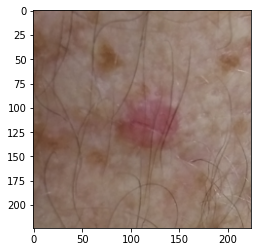

In [53]:
plt.imshow(dataset[1][0])

In [54]:
target_code_dict = create_category_index_dict(data_frame=data_pd, target_column=TARGET_COLUMN)

In [55]:
target_code_dict

{'False': 0, 'True': 1, 'UNK': 2}

**Split Training and Testing dataframe in stratify style:**

In [56]:
train_df, test_df = train_test_split(new_data_pd, test_size=0.2, stratify=new_data_pd['target'])

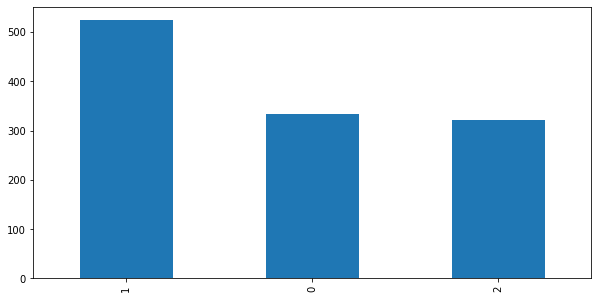

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
train_df['target'].value_counts().plot(kind='bar', ax=ax)

In [58]:
targets.value_counts()

1    656
0    416
2    402
Name: grew, dtype: int64

**Data augmentation and transformation:**

https://pytorch.org/vision/stable/transforms.html

In [59]:
transform_train = transforms.Compose([#transforms.ToPILImage(),
                                      transforms.Resize((IMG_H, IMG_W)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(25),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      #transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Transfer learning normalization requirements
                                    ])


transform_test = transforms.Compose([#transforms.ToPILImage(),
                                transforms.Resize((IMG_H, IMG_W)), 
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Transfer learning normalization requirements
                               ])

**Create train_loader and test_loader:**

In [60]:
train_data = ImageDataset(train_df, img_transform=transform_train, image_root_directory=raw_image_data_path)
test_data = ImageDataset(test_df, img_transform=transform_test, image_root_directory=raw_image_data_path)

train_loader = DataLoader(train_data, batch_size=B, shuffle=False)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False)

In [61]:
train_data[0][0].shape

torch.Size([3, 224, 224])

**ResNet18**

In [62]:
checkpoint_resnet18 = os.path.join(project_root_path_string, 'col_inference_grew_resnet18_checkpoint.pt')

In [63]:
model_resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [64]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [65]:
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, len(target_code_dict))

In [66]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [67]:
loss = nn.CrossEntropyLoss()

In [68]:
results_resnet18 = train_dl_model(model_resnet18, loss, train_loader, epochs=50, device=device, val_loader=test_loader, 
                                 checkpoint_file=checkpoint_resnet18,
                                 score_funcs={'Accuracy': accuracy_score})

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

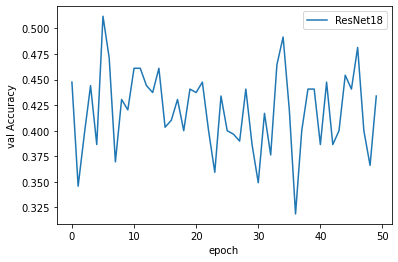

In [69]:
sns.lineplot(x='epoch', y='val Accuracy', data=results_resnet18, label='ResNet18')

In [70]:
results_resnet18

,epoch,total time,train loss,val loss,train Accuracy,val Accuracy
0,0,502.990885,1.328858,7.664335,0.368957,0.447458
1,1,558.059783,1.123606,6.594655,0.413062,0.345763
2,2,612.798792,1.070244,1.431448,0.431722,0.396610
3,3,667.662519,1.040404,1.167145,0.465649,0.444068
4,4,722.764476,1.039535,1.113941,0.439355,0.386441
5,5,777.842771,1.011031,1.060021,0.480916,0.511864
6,6,832.916985,0.999822,1.461017,0.475827,0.471186
7,7,887.875232,0.985603,1.224926,0.478372,0.369492
8,8,942.856384,0.983652,1.103834,0.501272,0.430508
9,9,997.834194,0.972598,1.117679,0.508906,0.420339


**Visualize Confusion Matrix for Resnet18:**

  0%|          | 0/3 [00:00<?, ?it/s]

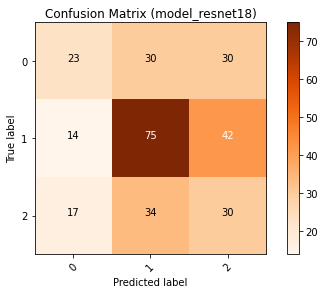

In [71]:
cm_model_resnet18, accuracy_score_model_resnet18, cls_report_resnet18 = construct_and_plot_confusion_matrix(model_resnet18, target_code_dict.values(), test_loader, 'model_resnet18')


**Resnet18 Accuracy Score:**

In [72]:
print('accuracy_score_model_resnet18:', accuracy_score_model_resnet18)

accuracy_score_model_resnet18: 0.43389830508474575


**Resnet18 Classification Report:**

In [73]:
print("cls_report_resnet18:\n", cls_report_resnet18)

cls_report_resnet18:
               precision    recall  f1-score   support

           0       0.43      0.28      0.34        83
           1       0.54      0.57      0.56       131
           2       0.29      0.37      0.33        81

    accuracy                           0.43       295
   macro avg       0.42      0.41      0.41       295
weighted avg       0.44      0.43      0.43       295

